<div class="title">Practical Assignment: Dimensionality Reduction</div>
<div class="subtitle">Métodos Avanzados en Aprendizaje Automático</div>
<div class="author"> XXX </div>

---

## Práctica realizada por Enrique Ernesto De Alvear Doñate y Javier Alarcon Caracena


**Initial Configuration**

This cell defines the configuration of Jupyter Notebooks.

In [1]:
%%html
<head><link rel="stylesheet" href="style.css"></head>

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

This cell imports the packages to be used (all of them quite standard).

In [3]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rc('figure', figsize=(15, 5))
seed = 123

# Introduction

This practical assignment consists in implementing a simplified version of the KernelPCA class of `sklearn`.

This class will contain three public methods: `fit()`, `transform()` and `fit_transform()`.

# Implementation of KPCA

## Requirements

The objective of this assignment is to complete the class `KPCA` sketched below, which should contain at least the following methods.

---
```python
__init__(self, n_components, kernel, gamma)
```
* This is the construction method for the class, with the following parameters:
    * `n_components`: Reduced dimension.
    * `kernel`: `'linear'` or `'rbf'`.
    * `gamma`: Kernel parameter $\gamma$ of the RBF kernel.
* This method should only store the parameters in fields of the class, to be used when needed.

---
```python
fit(self, X)
```
* This is the training method, with the following parameters:
    * `X`: Training data matrix $\mathbf{X}$. We assume it is centered.
* This method should compute the projecting direction, storing the useful information in fields of the class.

---
```python
transform(self, X)
```
* This is the method that computes the projection, with the following parameters:
    * `X`: New data matrix $\mathbf{X}$.
* This method will used the stored information in the class for projecting new points.
---
```python
fit_transform(self, X)
```
* This method firstly fit the model, and latter apply it over the training data, with the following parameters:
    * `X`: New data matrix $\mathbf{X}$.
* **NOTE**: This method can be implemented just calling the methods `fit` and `transform`; but also it can be computed more efficiently by theoretically computing the projection in this case. If this second approach is chosen, a brief explanation of why the implemented code is working will be required.

### Some recommendations:

* We will not pay attention to the dataset size, the examples used will be simple ones. We recommend the use of `eigs` from `scipy` that computes only the first `k` eigenvalues and eigenvectors. It will be necessary to ensure that the eigenvectors are ordered in terms of the largest eigenvalues.
* The projection direction should be deterministic, so the eigenvectors found should be flipped in terms of their sign to obtain always the same result.
* Projected data should be centered inside the method (so it has zero mean, but the std remains the same), being careful to also centered the projected new data points. For this purpose you can use the method [KernelCenterer()](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.KernelCenterer.html) from sklearn.
* Remember that the projection direction should have norm 1. This means that during the training the computed eigenvectors should be properly normalized and stored once normalized.

## Implementation

<div class="qst">

* Complete the `KPCA` class below, satisfying the described requirements.

</div>

In [71]:
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel, linear_kernel
from sklearn.gaussian_process.kernels import RBF
from sklearn.preprocessing import KernelCenterer as kc
from scipy.sparse.linalg import eigs
from sklearn.metrics.pairwise import pairwise_kernels

class KPCA():
    """
        Kernel PCA.
    """
    def __init__(self, n_components, kernel, gamma=None):
        
        self.n_components = n_components
        if kernel in ["linear", "rbf"]:
            self.kernel = kernel

        else: 
            raise Exception("invalid kernel")
        self.gamma = gamma
        self.eigval = None
        self.eigvec = None
        self.X_fitted = None
        self.centerer = kc()

    def fit(self, X):
        #Primero se crea el la matriz de kernel según el kernel utilizado
        if self.kernel == "linear":
            K_matrix = pairwise_kernels(X, metric = "linear")
        else:
            K_matrix = pairwise_kernels(X, metric = "rbf", **{"gamma": self.gamma})
        K_centered = self.centerer.fit_transform(K_matrix)#Se aplica el Kernel Centerer
        

        #Se calculan los autovalores y autovectores de la matriz de Kernel
        values, vectors = np.linalg.eigh(K_centered)
        
        #se reordenan para poder coger los mayores
        indices = values.argsort()[::-1]
        values = values[indices]
        vectors = vectors[:,indices]

        #Finalmente se guardan en los atributos correspondientes 
        self.eigval = np.sqrt(values[:self.n_components])
        self.eigvec = vectors[:,:self.n_components]

        #Se guarda una copia de los datos de entrenamiento para luego usarlos en el transform
        self.X_fitted = X

        return self


    def transform(self, X):
        #Primero hay que crear la matriz de kernel, la cual tiene que saber con qué datos se ha hecho el fit
        if self.kernel == "linear":
            K_matrix = pairwise_kernels(X,  self.X_fitted, metric = "linear")
        else:
            K_matrix = pairwise_kernels(X, self.X_fitted, metric = "rbf", **{"gamma": self.gamma})
        K = self.centerer.transform(K_matrix)#Se aplica el KernelCentralizer()
        eigvals_notzero = np.flatnonzero(self.eigval)#Para que dé igual que en PCA y KPCA se divide por los atuovectores, por lo tanto estos tienen que ser no nulos
        transformed_matrix = np.zeros_like(self.eigvec)
        transformed_matrix[:,eigvals_notzero] = self.eigvec[:, eigvals_notzero] / self.eigval[eigvals_notzero]#Creamos la matriz de la transformación

        x_new = np.dot(K, transformed_matrix) #Se aplica la transformación
        return x_new

    def fit_transform(self, X): 
        self.fit(X)
        return self.transform(X)

# Experiments with KPCA

## Comparative with *scikit-learn*

The following cell generates the *blobs* dataset and depicts it.

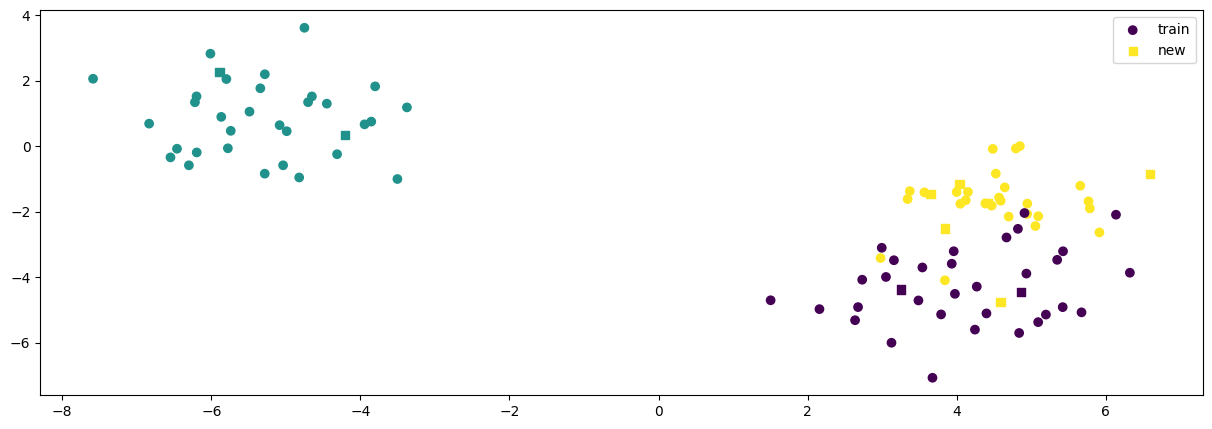

In [67]:
from sklearn.datasets import make_blobs
X, y = make_blobs(random_state=seed)
X_train = X[:90,:]; y_train=y[:90]
X_new = X[90:,:]; y_new=y[90:]

plt.scatter(X_train[:,0], X_train[:,1],c=y_train, label='train')
plt.scatter(X_new[:,0], X_new[:,1], c=y_new, marker='s', label='new')
plt.legend()
plt.show()

<div class="qst">

* Train and transform a classical PCA model over the training data (`X_train`), using both the implemented `KPCA` class using a linear kernel and the `PCA` class of `sklearn`.
* Transform using the previous two models the new data (`X_new`).
* Compare that both classes provide the same outputs (in terms of the eigenvectors and the data projections), describing the obtained results.
</div>

[47.73407845]
[47.73407845]
[[-2.91306683]
 [-2.56379231]
 [-4.80706454]
 [-4.59719367]
 [-3.08472867]
 [-2.33060981]
 [ 7.91074148]
 [ 5.61290113]
 [-4.47037834]
 [-3.13577591]]
[[-2.91306683]
 [-2.56379231]
 [-4.80706454]
 [-4.59719367]
 [-3.08472867]
 [-2.33060981]
 [ 7.91074148]
 [ 5.61290113]
 [-4.47037834]
 [-3.13577591]]


Text(0.5, 1.0, 'Comparación transformación KPCA con PCA, y dibujada la recya y=x para ver que son realmente iguales')

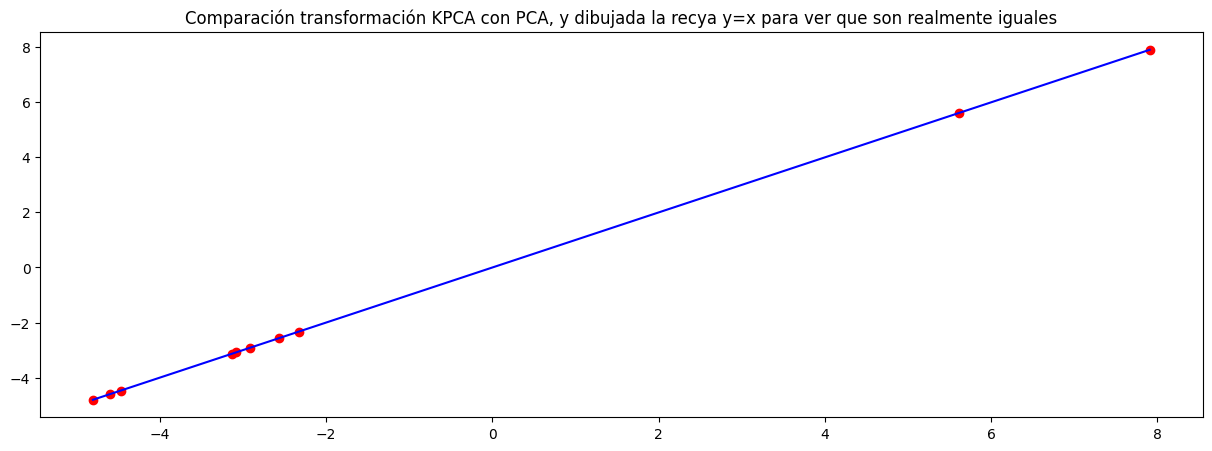

In [90]:
from sklearn.decomposition import PCA

kernel = 'linear'
n_components=1

model_my = KPCA(n_components=n_components, kernel=kernel)
model_sk = PCA(n_components=n_components)

model_my_fit = model_my.fit(X_train)
model_sk = model_sk.fit(X_train)
# Training of the models (complete).
# ...

# Comparative of the eigenvectors (complete).
# ...
print(model_my_fit.eigval)
print(model_sk.singular_values_)
# Comparative of the projections (complete).
# ...
x_mine = model_my_fit.transform(X_new) 
x_PCA = model_sk.transform(X_new)

print(x_mine)
print(x_PCA)

plt.scatter(x_mine, x_PCA, c='red')

x = np.linspace(min(x_mine), max(x_mine))

x = np.linspace(min(x_mine), max(x_mine))
plt.plot(x,x, c = "b")
plt.title("Comparación transformación KPCA con PCA, y dibujada la recya y=x para ver que son realmente iguales")


<div class="qst">

* Train and transform a Kernel PCA model using a RBF kernel over the training data (`X_train`), calling both the implemented `KPCA` class and the `KernelPCA` class of `sklearn`.
* Transform using the previous two models the new data (`X_new`).
* Compare that both classes provide the same outputs (in terms of the eigenvectors and the data projections), describing the obtained results.
</div>

[10.33496991]
[10.33496991]
[[-0.07659454]
 [-0.02687562]
 [-0.067595  ]
 [ 0.07106116]
 [-0.06317902]
 [-0.07478383]
 [-0.04358828]
 [-0.05299651]
 [-0.00195559]
 [-0.08395723]
 [-0.08205571]
 [ 0.20616435]
 [-0.03526467]
 [-0.0558991 ]
 [-0.08104275]
 [-0.03418746]
 [-0.06253856]
 [-0.07028975]
 [ 0.23538853]
 [-0.05364521]
 [-0.08110221]
 [ 0.18640239]
 [ 0.10403168]
 [-0.05754124]
 [-0.09353104]
 [-0.09232083]
 [-0.08618342]
 [-0.05684863]
 [-0.06926103]
 [-0.06496479]
 [-0.01144052]
 [-0.06707274]
 [-0.04670331]
 [ 0.0543778 ]
 [ 0.01057594]
 [-0.06821829]
 [-0.09628343]
 [ 0.21643132]
 [-0.00577325]
 [ 0.02487869]
 [-0.06512801]
 [-0.05108481]
 [-0.06098952]
 [ 0.17347026]
 [ 0.19500657]
 [ 0.23276039]
 [-0.03478202]
 [-0.05362232]
 [ 0.20867612]
 [-0.08562022]
 [-0.06657083]
 [-0.09239971]
 [-0.07412703]
 [ 0.07284089]
 [-0.06498641]
 [-0.07942346]
 [-0.05626823]
 [-0.08166019]
 [ 0.23950168]
 [ 0.19230991]
 [-0.0661966 ]
 [ 0.14816423]
 [-0.0408842 ]
 [-0.03677405]
 [ 0.2391219

Text(0.5, 1.0, 'Comparación transformación KPCA con KernelPCA, y dibujada la recya y=x para ver que son realmente iguales')

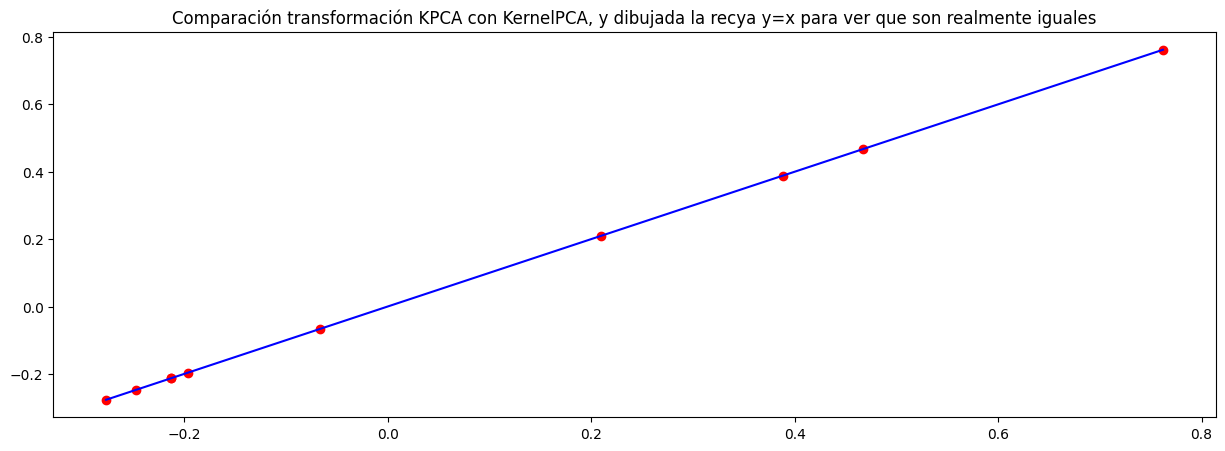

In [91]:
from sklearn.decomposition import KernelPCA

kernel = 'rbf'
n_components=1

# Model definition (complete).
model_my = KPCA(n_components=n_components, kernel=kernel, gamma = 1)
model_sk = KernelPCA(kernel="rbf",gamma=1, n_components=1)

# Training of the models (complete).
# ...

model_my_fit = model_my.fit(X_train)
model_sk = model_sk.fit(X_train)
# Training of the models (complete).
# ...

# Comparative of the eigenvectors (complete).
# ...
print(model_my_fit.eigval ** 2)
print(model_sk.eigenvalues_)


print(model_my_fit.eigvec)
print(model_sk.eigenvectors_)
# Comparative of the eigenvectors (complete).
# ...

# Comparative of the projections (complete).
# ...
x_mine = model_my_fit.transform(X_new) 
x_PCA = model_sk.transform(X_new)
plt.scatter(x_mine, x_PCA, c='red')
x = np.linspace(min(x_mine), max(x_mine))
plt.plot(x,x, c = "b")
plt.title("Comparación transformación KPCA con KernelPCA, y dibujada la recya y=x para ver que son realmente iguales")


Como podemos ver para ambas transformaciones, ya sea con Kernel Lineal

## Comparing linear kernel against Gaussian kernel

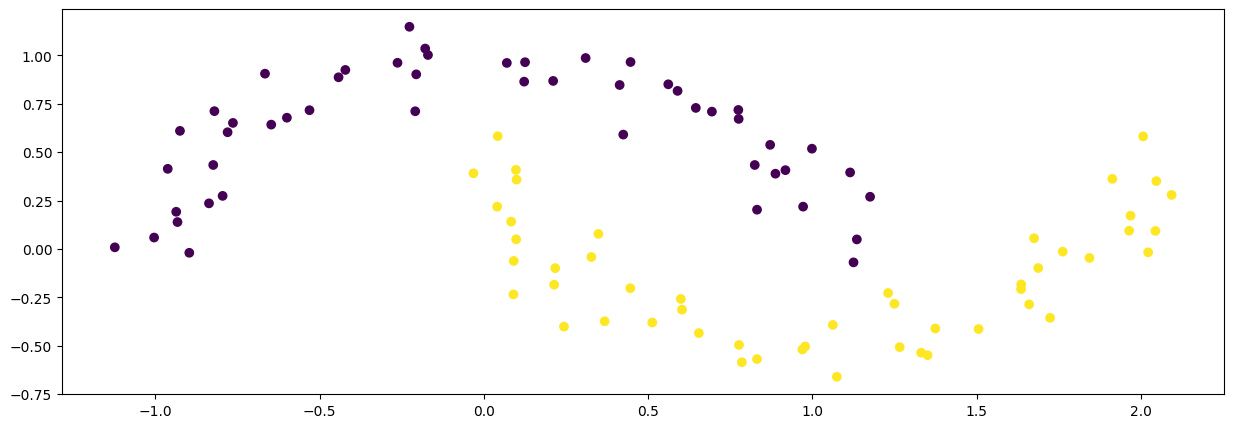

In [82]:
from sklearn.datasets import make_moons

X, y = make_moons(noise=1e-1, random_state=seed)

plt.scatter(X[:,0], X[:,1],c=y)

<div class="qst">

* Using the implemented class `KPCA` compare the result of transforming the above dataset using a linear kernel and an RBF one (looking for an appropriated hyperparameter `gamma` value).
* Is there some model able to properly project the classes separately?
</div>

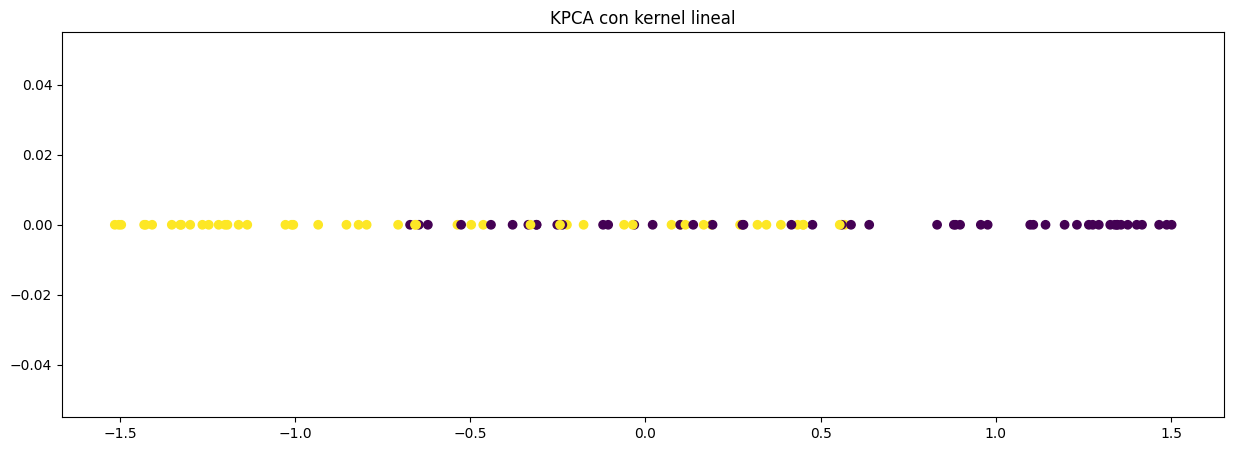

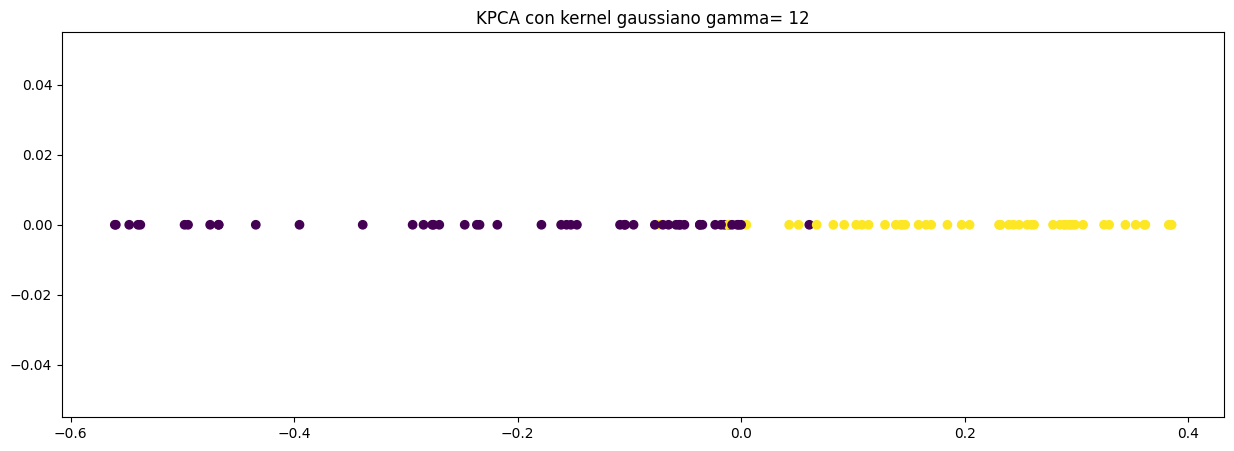

In [89]:
n_components=1
gamma = 12


model_linear = KPCA(n_components=n_components, kernel='linear')
model_rbf = KPCA(n_components=n_components, kernel='rbf', gamma = gamma)

x_KPCA_lin = model_linear.fit_transform(X)
x_KPCA_rbf = model_rbf.fit_transform(X)

plt.scatter(x_KPCA_lin, [0 for i in range(len(x_KPCA_lin))] , c = y)
plt.title("KPCA con kernel lineal")
plt.show()
plt.scatter(x_KPCA_rbf, [0 for i in range(len(x_KPCA_lin))], c = y)
plt.title(f"KPCA con kernel gaussiano gamma= {gamma}")
plt.show()